# Interpolative Seperable Density Fitting (ISDF) 

The ISDF implementation currently provides a THC-like factorization of the two electron integrals which should converge to the FFTDF representation of the ERIs in the limit of large THC rank. This differs from the assumption of using RSGDF throughout the rest of the resource estimation scripts. However, we typically are only interested in ISDF as an initial guess for the THC factors which are then subsequently reoptimized to regularize $\lambda$. The assumption here is that FFTDF / ISDF is a good enough approximation to the RSGDF ERIs and thus serves as a good initial guess.

Let's start by comparing the ISDF-MP2 energy as a function of the THC rank parameter, recall that $M = c_\mathrm{THC} N/2$, where $c_\mathrm{THC}$ is the THC rank parameter and $N$ is the number of spin orbitals. $M$ is what we call num_thc in the code. 

It's important to recall what we are doing in the ISDF algorithm, that is we solve

\begin{equation}

u_{p\mathrm{k}}^*(\mathbf{r}_i) u_{q\mathbf{k}'}(\mathbf{r}_i) = \sum_\mu^M \xi_\mu(\mathbf{r}_i) u_{p\mathrm{k}}^*(\mathbf{r}_\mu) u_{q\mathbf{k}'}(\mathbf{r}_\mu)

\end{equation}

for $\xi_\mu(\mathbf{r}_i)$ given a set of interpolating points $(\{r_\mu\})$ which are selected from the original real space $(\{\mathbf{r}_i\})$ (FFT) grid of size $N_g$ using the KMeans-CVT algorithm.

For the purposes of this notebook it is helpful to use a value of $N_g$ which is smaller than that required to fully converge the FFTDF error. We will investigate this more at the end of the tutorial. 

In [11]:
import numpy as np
from ase.build import bulk

from pyscf.pbc import gto, scf
from pyscf.pbc.tools import pyscf_ase
from pyscf.pbc.mp import KMP2 


ase_atom = bulk("C", "diamond", a=3.5)
cell = gto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(ase_atom)
cell.a = ase_atom.cell[:].copy()
cell.basis = "gth-szv"
cell.pseudo = "gth-hf-rev"
# Use a smaller value of Ng that would otherwise be suggested (~ 26^3) for
# expediency + to allow exact ISDF factorization for comparison.
cell.mesh = [11]*3
cell.verbose = 0
cell.build()

kmesh = [1, 1, 3]
kpts = cell.make_kpts(kmesh)
num_kpts = len(kpts)
mf = scf.KRHF(cell, kpts)
mf.kernel()
print("SCF energy: ", mf.e_tot)

# converged SCF energy with appropriate Ng = -10.388904514046914, mesh = 28^3


SCF energy:  -10.386655412717735


Now let's find the ISDF THC factors using the KMeans-CVT algorithm to find the interpolating points. It's easiest to use the helper function `solve_kmeans_kpisdf` which will perform the necessary steps. 

In [12]:
from kpoint_eri.factorizations.isdf import solve_kmeans_kpisdf

# Let's use the whole real space grid for some correctness checks first.
num_thc = np.prod(cell.mesh)
kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
print(kpt_thc.__dict__.keys())

dict_keys(['chi', 'zeta', 'G_mapping', 'xi'])


We see that the kpt_thc class has 4 attributes, `chi`, `xi`, `zeta` and `G_mapping`. `chi` corresponds to the cell periodic part of the Bloch orbital (i.e. $u_{p\mathbf{k}}(\mathbf{r}_\mu))$. `xi` corresponds to $\xi_{\mu}(\mathbf{r})$ in Eq. (1) above. To understand `zeta` and `G_mapping` it is helpful to recall we want to build

$$

(p\mathbf{k}pq\mathbf{k}-\mathbf{Q}|r\mathbf{k}'-\mathbf{Q} s\mathbf{k}') = \sum_{\mu\nu} u^*_{p\mathbf{k}}(\mathbf{r}_\mu))u_{p\mathbf{k}-\mathbf{{Q}}}(\mathbf{r}_\mu) \zeta_{\mu\nu}^{\mathbf{Q}\Delta \mathbf{G}_{\mathbf{Q}\mathbf{k}-\mathbf{Q}}\Delta\mathbf{G}_{\mathbf{Q}\mathbf{k}'-\mathbf{Q}}} u^*_{p\mathbf{k}'}(\mathbf{r}_\nu)u_{p\mathbf{k}-\mathbf{Q}}(\mathbf{r}_\nu)

$$

So `zeta` corresponds to $\zeta_{\mu\nu}^{\mathbf{Q}\Delta \mathbf{G}_{\mathbf{Q}\mathbf{k}-\mathbf{Q}}\Delta\mathbf{G}_{\mathbf{Q}\mathbf{k}'-\mathbf{Q}}}$ above, and `G_mapping` is a 2D array yielding the appropriate $\Delta G$ index given an index for $\mathbf{Q}$ and $\mathbf{k}$.

Let's look at an example to see that everything is correct.

In [13]:
from kpoint_eri.resource_estimates.utils.misc_utils import build_momentum_transfer_mapping

momentum_map = build_momentum_transfer_mapping(cell, kpts)
num_spatial_orbs = mf.mo_coeff[0].shape[-1]

# Pick a particular momentum transfer

Q_indx = 1
k_indx = 1
k_prime_indx = 0
k_minus_Q_indx = momentum_map[Q_indx, k_indx]
k_prime_minus_Q_indx = momentum_map[Q_indx, k_prime_indx]

eri_kindices = [k_indx, k_minus_Q_indx, k_prime_minus_Q_indx, k_prime_indx]
eri_mos = [mf.mo_coeff[kindx] for kindx in eri_kindices]
eri_kpts = [mf.kpts[kindx] for kindx in eri_kindices]

eri_exact = mf.with_df.ao2mo(eri_mos, eri_kpts, compact=False).reshape((num_spatial_orbs,)*4)

from kpoint_eri.resource_estimates.thc.integral_helper import KPTHCHelperDoubleTranslation

kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)

eri_thc = kthc_eri_helper.get_eri(eri_kindices)
# Can also do
# eri_exact = kthc_eri_helper.get_eri_exact(eri_kindices)

assert np.allclose(eri_thc, eri_exact)


Now let's check convergence of the integral error with the THC dimension or equivalently the THC rank parameter.

In [14]:
from kpoint_eri.resource_estimates.thc.integral_helper import KPTHCHelperDoubleTranslation
delta_eri = []
thc_ranks = np.arange(2, 20, 2)
for cthc in thc_ranks:
    num_thc = cthc * num_spatial_orbs
    kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
    kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
    eri_thc = kthc_eri_helper.get_eri(eri_kindices)
    eri_exact = kthc_eri_helper.get_eri_exact(eri_kindices)
    # Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
    delta_eri.append(np.max(np.abs(eri_thc-eri_exact))/num_kpts)


Let's look at the convergence of the integral error

Text(0, 0.5, 'max$|\\Delta(pq|rs)|$')

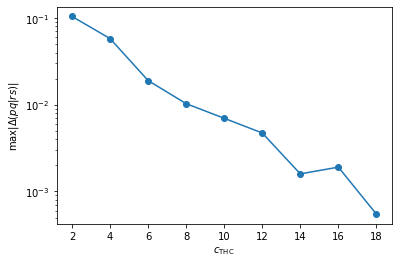

In [5]:
import matplotlib.pyplot as plt

plt.plot(thc_ranks, delta_eri, marker="o")
plt.yscale("log")
plt.xlabel(r"$c_{\mathrm{THC}}$")
plt.ylabel(r"max$|\Delta(pq|rs)|$")

Let's see how this corresponds to the MP2 error.

In [16]:
from kpoint_eri.resource_estimates.cc_helper.cc_helper import compute_emp2_approx

In [18]:

delta_mp2 = []
emp2_exact = KMP2(mf).kernel()[0] + mf.e_tot
for cthc in thc_ranks:
    num_thc = cthc * num_spatial_orbs
    kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
    kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
    emp2_approx = compute_emp2_approx(mf, kthc_eri_helper)
    # Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
    delta_mp2.append(emp2_exact - emp2_approx)

In [ ]:
plt.cla()
plt.plot(thc_ranks, np.abs(delta_mp2), marker="o")
plt.yscale("log")
plt.xlabel(r"$c_{\mathrm{THC}}$")
plt.ylabel(r"$|\Delta E_{\mathrm{MP2}}|$ (Ha)")

We see that apart from some non-monotonic behaviour (which is expected due to the non-linear nature of the ISDF procedure), that a relatively large rank parameter is required to obtain say $< 0.1$ mHa error per cell. Note this could likely be reduced by carefully selecting the orbital sets we perform ISDF on as oo, ov, and vv blocks exhibit different low-rank behaviour, but for quantum algorithms this is not relevant. 

### Optional: Effect of Mesh Density

You might be worried that we're cheating by only including 11^3 grid points, that we're not saving much with the ranks we're chosing.

Let us first see the fraction of points these ranks correspond to.

In [ ]:
plt.plot(thc_ranks, 100*np.array(thc_ranks)*num_spatial_orbs/(11**3), marker="o")
plt.xlabel(r"$c_{\mathrm{THC}}$")
plt.ylabel("Percentage of real space points selected")

Now let us crank up the FFTDF accuracy and see if the results change significantly. This cell will take around 10 minutes to run.

In [ ]:

results = {11: [], 15: [], 19: [], 21: [], 28: []}
#results = {11: [], 15: []}
for mesh in list(results.keys()):
    ase_atom = bulk("C", "diamond", a=3.5)
    cell = gto.Cell()
    cell.atom = pyscf_ase.ase_atoms_to_pyscf(ase_atom)
    cell.a = ase_atom.cell[:].copy()
    cell.basis = "gth-szv"
    cell.pseudo = "gth-hf-rev"
    # Use a smaller value of Ng that would otherwise be suggested (~ 26^3) for
    # expediency + to allow exact ISDF factorization for comparison.
    cell.mesh = [mesh]*3
    cell.verbose = 0
    cell.build()

    kmesh = [1, 1, 3]
    kpts = cell.make_kpts(kmesh)
    num_kpts = len(kpts)
    mf = scf.KRHF(cell, kpts)
    mf.kernel()
    print("SCF energy: ", mf.e_tot)

    from pyscf.pbc.mp import KMP2 
    emp2_exact = KMP2(mf).kernel()[0] + mf.e_tot
    print("Ng = {}^3, MP2 Correlation energy: {}".format(mesh, emp2_exact-mf.e_tot))
    from kpoint_eri.resource_estimates.cc_helper.cc_helper import compute_emp2_approx
    thc_ranks = np.arange(2, 20, 2)
    for cthc in thc_ranks:
        print(f"Running mesh = {mesh}, cthc = {cthc}")
        num_thc = cthc * num_spatial_orbs
        kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
        kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
        emp2_approx = compute_emp2_approx(mf, kthc_eri_helper)
        # Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
        results[mesh].append(emp2_exact - emp2_approx)

    plt.plot(thc_ranks, np.abs(results[mesh]), marker="o", label=f"$N_g = {mesh}^3$")
plt.yscale("log")
plt.xlabel(r"$c_{\mathrm{THC}}$")
plt.legend()
plt.ylabel(r"$|\Delta E_{\mathrm{MP2}}|$ (Ha)")



### Optional: Effect of Basis Set 

Another concern is that the basis set size is tiny so maybe things get worse as the basis set increases. Let's look into it by increasing the basis set size but still use a fairly coarse FFT grid, as we've seen it's not super important. This will also take several minutes to run.


In [ ]:

basis_results = {"gth-szv": [], "gth-dzvp": [], "gth-tzvp": []}
for basis in list(basis_results.keys()):
    ase_atom = bulk("C", "diamond", a=3.5)
    cell = gto.Cell()
    cell.atom = pyscf_ase.ase_atoms_to_pyscf(ase_atom)
    cell.a = ase_atom.cell[:].copy()
    cell.basis = basis 
    cell.exp_to_discard = 0.1
    cell.pseudo = "gth-hf-rev"
    # Use a smaller value of Ng that would otherwise be suggested (~ 26^3) for
    # expediency + to allow exact ISDF factorization for comparison.
    cell.mesh = [15]*3
    cell.verbose = 0
    cell.build()

    kmesh = [1, 1, 3]
    kpts = cell.make_kpts(kmesh)
    num_kpts = len(kpts)
    mf = scf.KRHF(cell, kpts)
    mf.kernel()
    print("SCF energy: ", mf.e_tot)

    num_spatial_orbs = mf.mo_coeff[0].shape[-1]
    from pyscf.pbc.mp import KMP2 
    emp2_exact = KMP2(mf).kernel()[0] + mf.e_tot
    print("basis = {}, MP2 Correlation energy: {}".format(basis, emp2_exact-mf.e_tot))
    from kpoint_eri.resource_estimates.cc_helper.cc_helper import compute_emp2_approx
    thc_ranks = np.arange(2, 20, 2)
    for cthc in thc_ranks:
        print(f"Running basis = {basis}, cthc = {cthc}")
        num_thc = cthc * num_spatial_orbs
        kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
        kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
        emp2_approx = compute_emp2_approx(mf, kthc_eri_helper)
        # Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
        basis_results[basis].append(emp2_exact - emp2_approx)

    plt.plot(thc_ranks*num_spatial_orbs, np.abs(basis_results[basis]), marker="o", label=f"basis = {basis}")
plt.yscale("log")
plt.xlabel(r"$M$")
plt.legend()
plt.ylabel(r"$|\Delta E_{\mathrm{MP2}}|$ (Ha)")

In [ ]:

for basis in list(basis_results.keys()):
    plt.plot(thc_ranks, np.abs(basis_results[basis]), marker="o", label=f"basis = {basis}")
plt.yscale("log")
plt.xlabel(r"$c_{\mathrm{THC}}$")
plt.legend()
plt.ylabel(r"$|\Delta E_{\mathrm{MP2}}|$ (Ha)")

## Effect on $\lambda$ 

Now let us investigate the $\lambda$ dependence of our ISDF-THC factorization. We will revert back to the minimal example from earlier.

In [20]:

ase_atom = bulk("C", "diamond", a=3.5)
cell = gto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(ase_atom)
cell.a = ase_atom.cell[:].copy()
cell.basis = "gth-dzv"
cell.pseudo = "gth-hf-rev"
# Use a smaller value of Ng that would otherwise be suggested (~ 26^3) for
# expediency + to allow exact ISDF factorization for comparison.
cell.mesh = [15]*3
cell.verbose = 0
cell.build()

kmesh = [1, 1, 3]
kpts = cell.make_kpts(kmesh)
num_kpts = len(kpts)
mf = scf.KRHF(cell, kpts)
mf.kernel()
print("SCF energy: ", mf.e_tot)

# converged SCF energy with appropriate Ng = -10.388904514046914, mesh = 28^3

from kpoint_eri.resource_estimates.thc.compute_lambda_thc import compute_lambda
from kpoint_eri.factorizations.isdf import solve_kmeans_kpisdf
hcore = np.asarray([C.conj().T @ hc @ C for C, hc in zip(mf.mo_coeff, mf.get_hcore())])
num_spatial_orbs = hcore.shape[-1]
thc_ranks = np.arange(2, 20, 2)
emp2_exact = KMP2(mf).kernel()[0]
np.random.seed(7)
print(f"FFTDF MP2 Correlation energy: {emp2_exact}")
for cthc in thc_ranks:
    num_thc = cthc * num_spatial_orbs
    kpt_thc = solve_kmeans_kpisdf(mf, num_thc, verbose=False)
    kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
    # Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
    lambda_tot, lambda_one, lambda_two = compute_lambda(hcore, kthc_eri_helper)
    emp2_approx = compute_emp2_approx(mf, kthc_eri_helper) - mf.e_tot
    emp2_error = abs(emp2_approx - emp2_exact)
    print(f"cthc = {cthc}, MP2 error: {emp2_error:4.3e}, lambda = {lambda_tot:4.3e}")
    if emp2_error < 1e-4:
        print(f"--> MP2 error < 0.1: {emp2_error:4.3e}, lambda = {lambda_tot:4.3e}")

SCF energy:  -10.46895531337281
FFTDF MP2 Correlation energy: -0.18060810513993086
cthc = 2, MP2 error: 3.041e-03, lambda = 1.507e+03
cthc = 4, MP2 error: 1.037e-02, lambda = 2.674e+03
cthc = 6, MP2 error: 5.781e-03, lambda = 4.644e+03
cthc = 8, MP2 error: 1.301e-03, lambda = 2.293e+04
cthc = 10, MP2 error: 1.902e-03, lambda = 4.647e+04
cthc = 12, MP2 error: 4.714e-04, lambda = 8.540e+04
cthc = 14, MP2 error: 1.962e-04, lambda = 2.886e+05
cthc = 16, MP2 error: 3.082e-05, lambda = 3.822e+05
--> MP2 error < 0.1: 3.082e-05, lambda = 3.822e+05
cthc = 18, MP2 error: 7.653e-05, lambda = 1.465e+05
--> MP2 error < 0.1: 7.653e-05, lambda = 1.465e+05


Now we can try to improve $\lambda$ by reoptimizing the THC factors using our ISDF factors as an initial guess. Practically this should mean we can use a smaller THC rank parameter for comparable MP2 accuracy. Note reoptimizing the THC factors is quite expensive. This cell may take 20 minutes to run. You should see that for a $c_\mathrm{THC}=6$ the MP2 error is reduced by an order of magnitude.

In [21]:
from kpoint_eri.factorizations.thc_jax import kpoint_thc_via_isdf
from kpoint_eri.factorizations.pyscf_chol_from_df import cholesky_from_df_ints

# Recall we need RSGDF integrals to fit to.
rsmf = scf.KRHF(mf.cell, mf.kpts).rs_density_fit()
rsmf.kernel()
mymp = KMP2(rsmf)
emp2_rsgdf = mymp.kernel()[0]
Luv = cholesky_from_df_ints(mymp)
np.random.seed(7)
print(f"RSGDF emp2: {emp2_rsgdf}")
cthc = 6
num_thc = cthc * num_spatial_orbs
# Here we use the helper function kpoint_thc_via_isdf which will first find
# the ISDF factors and feed these into the BFGS and AdaGrad solvers.
kpt_thc, _ = kpoint_thc_via_isdf(mf, Luv, num_thc, verbose=False)
kthc_eri_helper = KPTHCHelperDoubleTranslation(chi=kpt_thc.chi, zeta=kpt_thc.zeta, kmf=mf)
# Note pyscf omits a normalization factor of 1/Nk in their definition of ERIs
lambda_tot, lambda_one, lambda_two = compute_lambda(hcore, kthc_eri_helper)
emp2_approx = compute_emp2_approx(mf, kthc_eri_helper) - mf.e_tot # only compare correlation energy.
emp2_error = abs(emp2_approx - emp2_rsgdf)
print(f"cthc = {cthc}, MP2 error: {emp2_error:4.3e}, lambda = {lambda_tot:4.3e}")

RSGDF emp2: -0.1794066040870724
Batch size in GB: 0.0020599365234375
Time to evaluate loss function : 0.1537
loss 137.26650504426283
lambda_z 166.74477851252007
penalty_param 0.8232132140434979
Initial Grad
(DeviceArray([-2.32973984e+02, -8.34609909e+02, -3.73817105e+02, ...,
              2.83839992e-01, -2.49309183e-01,  5.54482127e-17],            dtype=float64),)
# Time to evaluate gradient: 1.5925
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       175104     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30257D+04    |proj g|=  1.52385D+03


 This problem is unconstrained.



At iterate   98    f=  7.06792D+01    |proj g|=  6.09690D-01

At iterate  196    f=  7.06371D+01    |proj g|=  6.66324D-02

At iterate  294    f=  7.05940D+01    |proj g|=  7.38934D-02

At iterate  392    f=  7.05634D+01    |proj g|=  1.09127D-01

At iterate  490    f=  7.05520D+01    |proj g|=  6.47169D-02

At iterate  588    f=  7.05488D+01    |proj g|=  7.13232D-02

At iterate  686    f=  7.05478D+01    |proj g|=  1.22480D-01

At iterate  784    f=  7.05434D+01    |proj g|=  7.28555D-02

At iterate  882    f=  7.05399D+01    |proj g|=  1.17562D-01

At iterate  980    f=  7.05385D+01    |proj g|=  9.99990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn